## Sample Project: Credit Worthiness

A bank wants to use performance of an in-house credit product to create a risk model. A sample of applicants for the original credit product was selected. Credit bureau data describing these individuals (at the time of application) was recorded and stored in the CREDIT data set. The ultimate disposition of the loan was determined (paid off or bad debt). For loans rejected at the time of application, a disposition was inferred from credit bureau records on loans obtained in a similar time frame.

In [1]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
from IPython.display import Image
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score

%matplotlib inline

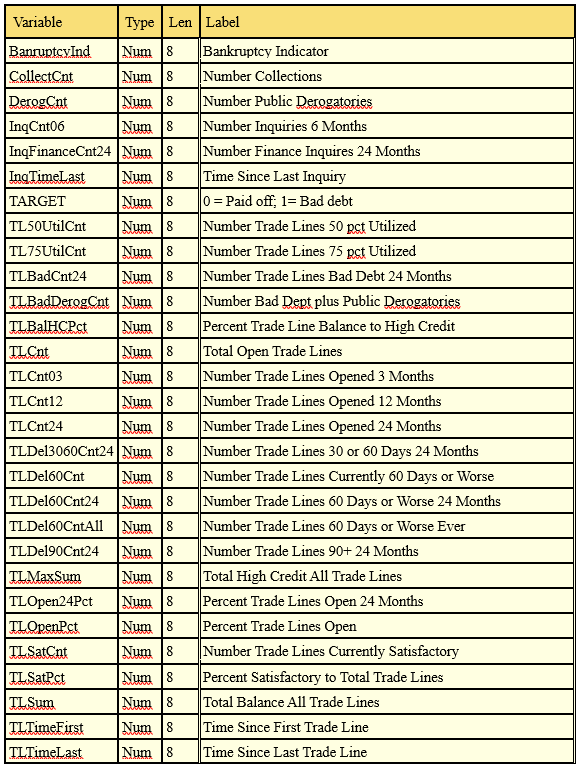

In [2]:
# variable definitions
Image(filename = 'credit_table.png', width = 400, height = 650)

### Part I: Data Cleansing

In [3]:
import pandas as pd 

Credit = pd.read_csv('Credit.csv').dropna() 
Credit.info() 

# get rid of the $ and % sign in the following columns 

Credit['TLSum'] = Credit[['TLSum']].replace('[\$,]','',regex=True).astype(float) 
Credit['TLMaxSum'] = Credit[['TLMaxSum']].replace('[\$,]','',regex=True).astype(float) 
Credit['TLBalHCPct'] = Credit['TLBalHCPct'].replace('%','',regex=True).astype('float')/100 
Credit['TLSatPct'] = Credit['TLSatPct'].replace('%','',regex=True).astype('float')/100 
Credit['TLOpenPct'] = Credit['TLOpenPct'].replace('%','',regex=True).astype('float')/100 
Credit['TLOpen24Pct'] = Credit['TLOpen24Pct'].replace('%','',regex=True).astype('float')/100 

Credit.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2728 entries, 0 to 2999
Data columns (total 30 columns):
TARGET             2728 non-null int64
ID                 2728 non-null int64
DerogCnt           2728 non-null int64
CollectCnt         2728 non-null int64
BanruptcyInd       2728 non-null int64
InqCnt06           2728 non-null int64
InqTimeLast        2728 non-null float64
InqFinanceCnt24    2728 non-null int64
TLTimeFirst        2728 non-null int64
TLTimeLast         2728 non-null int64
TLCnt03            2728 non-null int64
TLCnt12            2728 non-null int64
TLCnt24            2728 non-null int64
TLCnt              2728 non-null float64
TLSum              2728 non-null object
TLMaxSum           2728 non-null object
TLSatCnt           2728 non-null float64
TLDel60Cnt         2728 non-null int64
TLBadCnt24         2728 non-null int64
TL75UtilCnt        2728 non-null float64
TL50UtilCnt        2728 non-null float64
TLBalHCPct         2728 non-null object
TLSatPct           272

TARGET   ID  DerogCnt  CollectCnt  BanruptcyInd  InqCnt06  InqTimeLast  \
0       0   66         1           1             0         7          1.0   
1       0  116         1           1             0         2          1.0   
2       0  124         0           0             0         1          1.0   
3       0  128         0           0             0         6          3.0   
4       0  143         0           0             0         1          0.0   

   InqFinanceCnt24  TLTimeFirst  TLTimeLast     ...       TL50UtilCnt  \
0                4          125           3     ...               4.0   
1                0          252          18     ...               2.0   
2                4          254          12     ...               3.0   
3                6          154           3     ...               5.0   
4                1          311          17     ...               3.0   

   TLBalHCPct  TLSatPct  TLDel3060Cnt24  TLDel90Cnt24  TLDel60CntAll  \
0        0.85      0.67               0             0              1   
1        0.48      0.30               0             1              4   
2        0.84      0.67               0             1              1   
3        0.73      0.76               0             1              1   
4        0.88      0.63               0             0              1   

   TLOpenPct  TLBadDerogCnt  TLDel60Cnt24  TLOpen24Pct  
0       0.58              0             0         0.71  
1       0.40              2             1         0.50  
2       0.50              1             1         0.33  
3       0.53              1             1         1.22  
4       0.63              0             0         0.20  

[5 rows x 30 columns]

In [4]:
# What percentage of observations in the sample has TARGET=1?
# apply the value_counts() function to the Credit["TARGET"] column

Credit["TARGET"].value_counts()

0    2257
1     471
Name: TARGET, dtype: int64

In [5]:
# Randomly split the dataset, so that the training dataset includes 60% of the original dataset. 

from sklearn.model_selection import train_test_split

# define the X and y variables. X includes all variables except ID and TARGET
X = Credit.drop(['TARGET', 'ID'], axis=1)
y = Credit["TARGET"]

x_columns = X.columns

# Instruction: split the dataset to training and test

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.6, random_state = 1)

C:\Users\pzx0002\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


### Part II: Decision Tree Model

In [6]:
from sklearn.tree import DecisionTreeClassifier
# Instruction: build a decision tree model with the training dataset

tree1 = DecisionTreeClassifier(max_depth = 3)
tree1.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

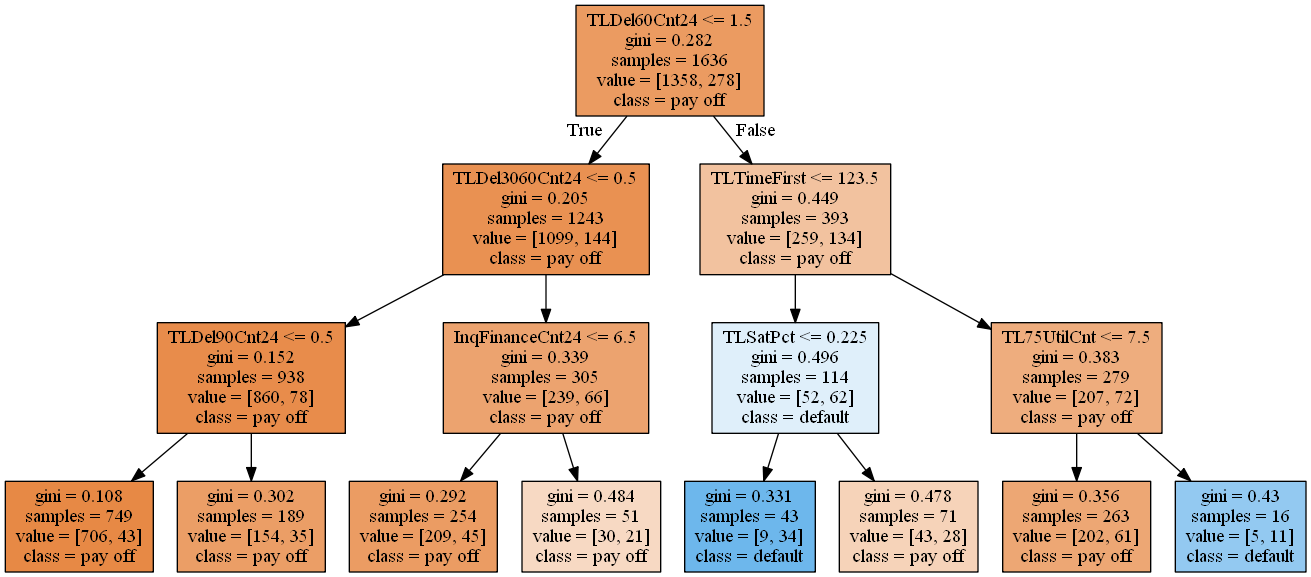

In [7]:
# Print the tree image
import pydotplus
from sklearn.externals.six import StringIO
from sklearn.tree import export_graphviz

# This function creates images of tree models using pydot
def print_tree(estimator, features, class_names=None, filled=True):
    tree = estimator
    names = features
    color = filled
    classn = class_names
    
    dot_data = StringIO()
    export_graphviz(estimator, out_file=dot_data, feature_names=features, class_names=classn, filled=filled)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    return(graph)

graph = print_tree(tree1, features=x_columns, class_names=["pay off", "default"])
graph.write_png("tree.png")
Image(graph.create_png())

In [8]:
# print out the if-then conditions
from sklearn.tree import _tree

def tree_to_code(tree, feature_names):

    '''
    feature_names: list
        The feature names of the dataset used for building the decision tree
    '''

    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print("def tree({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print("{}else:  # if {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print("{}return {}".format(indent, tree_.value[node]))

    recurse(0, 1)
    

tree_to_code(tree1, list(x_columns))

def tree(DerogCnt, CollectCnt, BanruptcyInd, InqCnt06, InqTimeLast, InqFinanceCnt24, TLTimeFirst, TLTimeLast, TLCnt03, TLCnt12, TLCnt24, TLCnt, TLSum, TLMaxSum, TLSatCnt, TLDel60Cnt, TLBadCnt24, TL75UtilCnt, TL50UtilCnt, TLBalHCPct, TLSatPct, TLDel3060Cnt24, TLDel90Cnt24, TLDel60CntAll, TLOpenPct, TLBadDerogCnt, TLDel60Cnt24, TLOpen24Pct):
  if TLDel60Cnt24 <= 1.5:
    if TLDel3060Cnt24 <= 0.5:
      if TLDel90Cnt24 <= 0.5:
        return [[706.  43.]]
      else:  # if TLDel90Cnt24 > 0.5
        return [[154.  35.]]
    else:  # if TLDel3060Cnt24 > 0.5
      if InqFinanceCnt24 <= 6.5:
        return [[209.  45.]]
      else:  # if InqFinanceCnt24 > 6.5
        return [[30. 21.]]
  else:  # if TLDel60Cnt24 > 1.5
    if TLTimeFirst <= 123.5:
      if TLSatPct <= 0.22499999403953552:
        return [[ 9. 34.]]
      else:  # if TLSatPct > 0.22499999403953552
        return [[43. 28.]]
    else:  # if TLTimeFirst > 123.5
      if TL75UtilCnt <= 7.5:
        return [[202.  61.]]
      else

In [9]:
# create prediction
y_pred_tree = tree1.predict(X_test)
# print model performance
# model evaluation 1: confusion matrix
print(confusion_matrix(y_test, y_pred_tree))

[[881  18]
 [179  14]]


In [10]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_tree).ravel()
# model evaluation 2: sensitivity & specificty
print("Accuracy = %s" %((tp+tn)/(tp+fn+tn+fp)))
print("Sensitivity = %s" %(tp/(tp+fn)))
print("Specificity = %s" %(tn/(tn+fp)))

Accuracy = 0.8195970695970696
Sensitivity = 0.07253886010362694
Specificity = 0.9799777530589544


In [11]:
# model evaluation 3: precision & recall & F1_score
print(classification_report(y_test, y_pred_tree))

             precision    recall  f1-score   support

          0       0.83      0.98      0.90       899
          1       0.44      0.07      0.12       193

avg / total       0.76      0.82      0.76      1092



#### According to the tree image, explain whether applicant 66 (ID = 66; the first applicant in the data table) will default on a loan.

In [12]:
# Instruction: generate the probability for the whole dataset and save the probability in a new column
Credit["predict_prob"] = tree1.predict_proba(X)[:,1]

# Instruction: print out the first five rows. The ID = 66 is the very first record. Find out the predict_prob value for this first row
Credit[["ID","predict_prob"]].head()

ID  predict_prob
0   66      0.057410
1  116      0.185185
2  124      0.185185
3  128      0.185185
4  143      0.057410

In [13]:
# print out variable importances
list(zip(X_train, tree1.feature_importances_))

[('DerogCnt', 0.0),
 ('CollectCnt', 0.0),
 ('BanruptcyInd', 0.0),
 ('InqCnt06', 0.0),
 ('InqTimeLast', 0.0),
 ('InqFinanceCnt24', 0.061567869152977316),
 ('TLTimeFirst', 0.17410955936176664),
 ('TLTimeLast', 0.0),
 ('TLCnt03', 0.0),
 ('TLCnt12', 0.0),
 ('TLCnt24', 0.0),
 ('TLCnt', 0.0),
 ('TLSum', 0.0),
 ('TLMaxSum', 0.0),
 ('TLSatCnt', 0.0),
 ('TLDel60Cnt', 0.0),
 ('TLBadCnt24', 0.0),
 ('TL75UtilCnt', 0.08244432113525782),
 ('TL50UtilCnt', 0.0),
 ('TLBalHCPct', 0.0),
 ('TLSatPct', 0.11079892325666978),
 ('TLDel3060Cnt24', 0.10761749034347881),
 ('TLDel90Cnt24', 0.06489796716499434),
 ('TLDel60CntAll', 0.0),
 ('TLOpenPct', 0.0),
 ('TLBadDerogCnt', 0.0),
 ('TLDel60Cnt24', 0.39856386958485523),
 ('TLOpen24Pct', 0.0)]

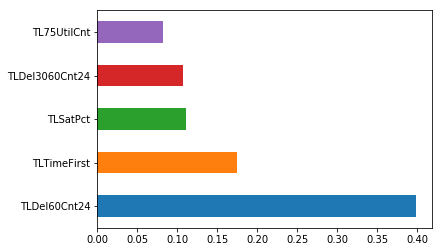

In [14]:
# We can also plot the important features
%matplotlib inline

feat_importances = pd.Series(tree1.feature_importances_, index=X.columns)
feat_importances.nlargest(5).plot(kind='barh')

### Part III: Random Forest Model

In [15]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor

# play around with the setting for max_features
for i in range(1, 11):
    rfc2 = RandomForestClassifier(max_features=i, random_state=1)
    rfc2.fit(X_train, y_train)
    pred2 = rfc2.predict(X_test)
    print("Accuracy for %s feature(s) equals %s" %(i, accuracy_score(y_test, pred2)))

Accuracy for 1 feature(s) equals 0.8168498168498168
Accuracy for 2 feature(s) equals 0.8214285714285714
Accuracy for 3 feature(s) equals 0.8214285714285714
Accuracy for 4 feature(s) equals 0.8214285714285714
Accuracy for 5 feature(s) equals 0.8177655677655677
Accuracy for 6 feature(s) equals 0.8223443223443223
Accuracy for 7 feature(s) equals 0.8195970695970696
Accuracy for 8 feature(s) equals 0.8287545787545788
Accuracy for 9 feature(s) equals 0.8195970695970696
Accuracy for 10 feature(s) equals 0.8269230769230769


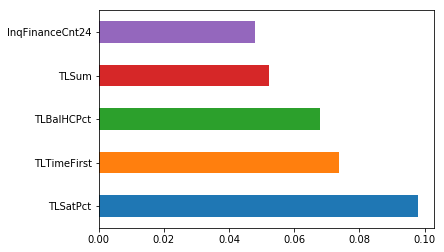

In [16]:
rfc8 = RandomForestClassifier(max_features=8, random_state=1)
rfc8.fit(X_train, y_train)

feat_importances = pd.Series(rfc8.feature_importances_, index=X.columns)
feat_importances.nlargest(5).plot(kind='barh')

When using black box machine learning algorithms like random forest and boosting, it is hard to understand the relations between predictors and model outcome. For example, in terms of random forest, all we get is the feature importance. Although we can know which feature is significantly influencing the outcome based on the importance calculation, it really sucks that we don’t know in which direction it is influencing. And in most of the real cases, the effect is non-monotonic. We need some powerful tools to help understanding the complex relations between predictors and model prediction.

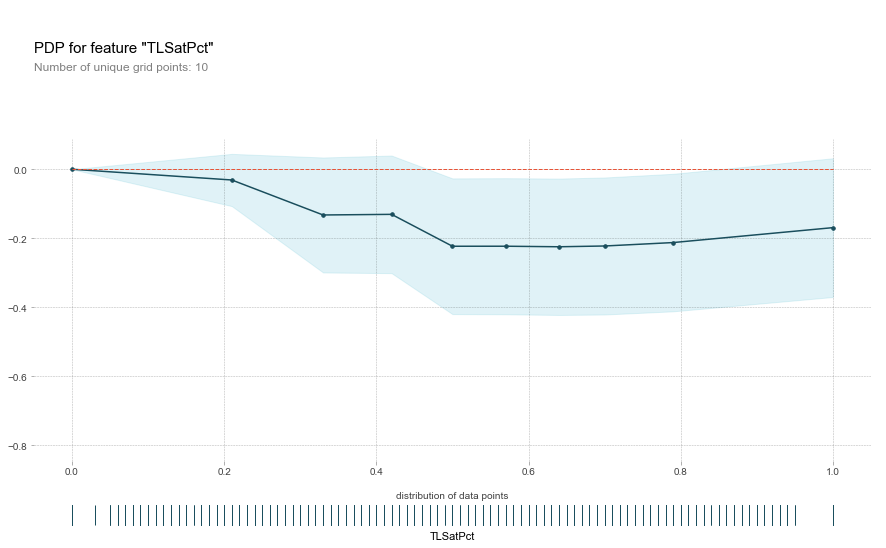

In [17]:
# https://pdpbox.readthedocs.io/en/latest/

from pdpbox.pdp import pdp_isolate, pdp_plot
pdp_TLSatPct = pdp_isolate(model=rfc8, dataset=Credit, model_features=x_columns,feature='TLSatPct')
fig, axes = pdp_plot(pdp_isolate_out=pdp_TLSatPct,feature_name='TLSatPct',plot_pts_dist=True)

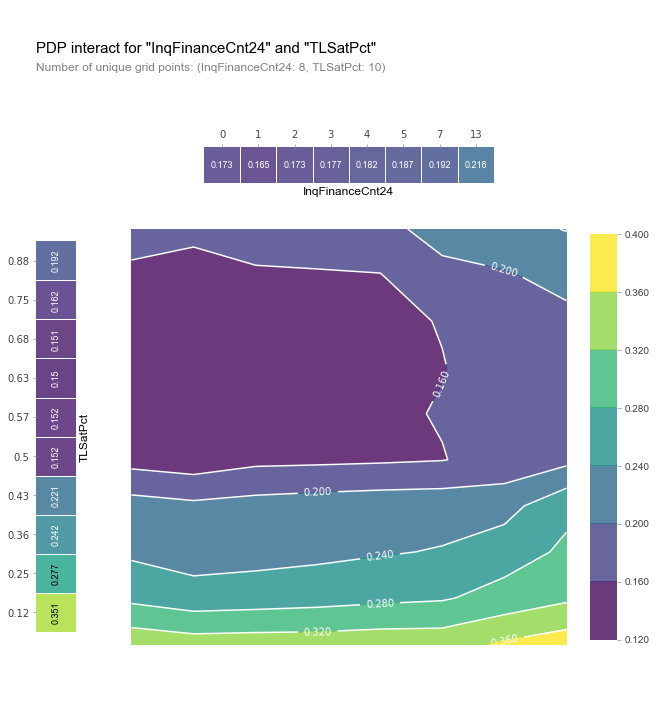

In [18]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot
inter1 = pdp_interact(model=rfc8, dataset=Credit, model_features=x_columns,features=['InqFinanceCnt24', 'TLSatPct'], num_grid_points=[10, 10], percentile_ranges=[(5, 95), (5, 95)])
fig, axes = pdp_interact_plot(pdp_interact_out=inter1, feature_names=['InqFinanceCnt24', 'TLSatPct'], plot_type='contour', x_quantile=True, plot_pdp=True)